In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from PIL import Image
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
#Image transformations

image_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Importing Dataset 
data = {
    'train':
    datasets.ImageFolder(root='/content/drive/MyDrive/VR_project/mask_code/dataset2/train', transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root='/content/drive/MyDrive/VR_project/mask_code/dataset2/test', transform=image_transforms['test']),
}

# Dataloader iterators, used for making batches
dataloaders = {
    'train': DataLoader(data['train'], batch_size=100, shuffle=True),
    'test': DataLoader(data['test'], batch_size=100, shuffle=True)
}

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
#Importing MobileNetv2 model
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [6]:
# Holding the starting layers of MobileNetv2
for param in model.parameters():
    param.requires_grad = False

In [7]:
# Making a classifier
model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(32, 2), 
                      nn.LogSoftmax(dim=1))

In [8]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

371234


In [9]:
# GPU Support
if torch.cuda.is_available():
    print('training on GPU')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")

training on GPU


In [10]:
from tqdm.notebook import tqdm

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs,device):
    train_loss = []
    test_loss = []
    test_accuracy = []
    for epoch in tqdm(range(epochs)):

        # Train model
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in (train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        # Evaluate model
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in (val_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)          
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        train_loss.append(training_loss)
        test_loss.append(valid_loss)
        test_accuracy.append(num_correct / num_examples)
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,valid_loss, num_correct / num_examples))

    return train_loss, test_loss,test_accuracy


In [11]:
# Enabling GPU
model=model.to(device)
print(device)

cuda:0


In [14]:
# Defining optimizer and Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [15]:
# Training model
(train_loss,test_loss,test_accuracy) = train(model, optimizer,loss,dataloaders['train'],dataloaders['test'],100,device)

Epoch: 0, Training Loss: 0.5454, Validation Loss: 0.2899, accuracy = 0.9918
Epoch: 1, Training Loss: 0.2369, Validation Loss: 0.1444, accuracy = 0.9590
Epoch: 2, Training Loss: 0.0906, Validation Loss: 0.0750, accuracy = 0.9836
Epoch: 3, Training Loss: 0.0475, Validation Loss: 0.0612, accuracy = 0.9918
Epoch: 4, Training Loss: 0.0447, Validation Loss: 0.1078, accuracy = 0.9836
Epoch: 5, Training Loss: 0.0504, Validation Loss: 0.0662, accuracy = 0.9918
Epoch: 6, Training Loss: 0.0216, Validation Loss: 0.0401, accuracy = 0.9836
Epoch: 7, Training Loss: 0.0143, Validation Loss: 0.0781, accuracy = 0.9918
Epoch: 8, Training Loss: 0.0493, Validation Loss: 0.0910, accuracy = 0.9918
Epoch: 9, Training Loss: 0.0257, Validation Loss: 0.0744, accuracy = 0.9836
Epoch: 10, Training Loss: 0.0177, Validation Loss: 0.0755, accuracy = 0.9836
Epoch: 11, Training Loss: 0.0309, Validation Loss: 0.0730, accuracy = 0.9836
Epoch: 12, Training Loss: 0.0250, Validation Loss: 0.0619, accuracy = 0.9836
Epoch: 13

## Graphs

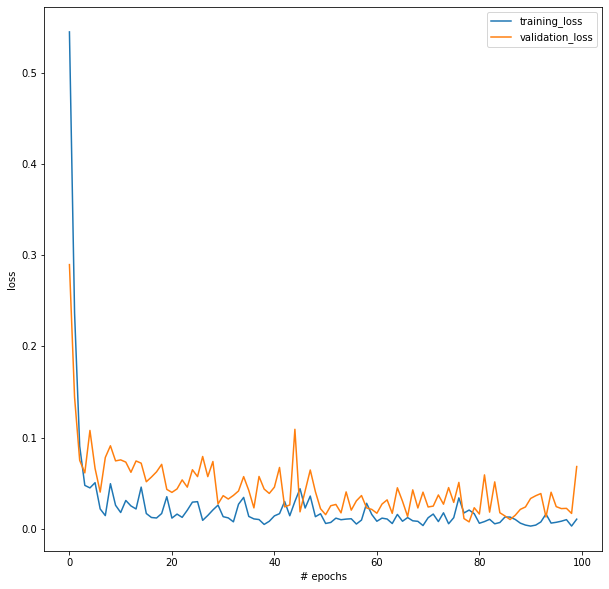

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.lineplot(data=train_loss)
sns.lineplot(data=test_loss)
plt.xlabel("# epochs")
plt.ylabel("loss")
plt.legend(['training_loss','validation_loss'])


Text(0, 0.5, 'Validation accuracy')

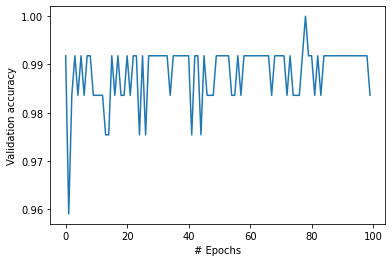

In [17]:
sns.lineplot(data=test_accuracy)
plt.xlabel("# Epochs")
plt.ylabel("Validation accuracy")

In [18]:
# Saving the model
torch.save(model, "final_model.pth")